In [1]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Assignment4').getOrCreate()

In [2]:
#load dataset
uber_df = spark.read.csv("D:\\UberApril14.csv", inferSchema = True, header = True)

In [3]:
print(uber_df.count(), len(uber_df.columns)) # we have 56416 rows and 4 columns

564516 4


In [4]:
uber_df.groupBy('Base').count().orderBy('count', ascending=False).show()
#The trips are not equally distributed, the bases B02682 and B02598 are dominating the market
# B02682 has the most trips with 227808 trips (40.35% of all trips)
# B02598 has 32.46% of all trips
# B02617 has 19.13% of all trips
# B02512 has 6.29% of all trips
# B02764 has the lowest amount of trips with 9908 trips (1.76%)

+------+------+
|  Base| count|
+------+------+
|B02682|227808|
|B02598|183263|
|B02617|108001|
|B02512| 35536|
|B02764|  9908|
+------+------+



In [5]:
uber_df.printSchema() 
#features for each trip are date/time, latitude and longitude of pickup location, as well as the TLC base company code of the uber pickup
# date/time and base are in the string format, but not included in the model 
# base needs no transformation because it is the target variable

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)



In [6]:
uber_df.show()

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|4/1/2014 0:11:00| 40.769|-73.9549|B02512|
|4/1/2014 0:17:00|40.7267|-74.0345|B02512|
|4/1/2014 0:21:00|40.7316|-73.9873|B02512|
|4/1/2014 0:28:00|40.7588|-73.9776|B02512|
|4/1/2014 0:33:00|40.7594|-73.9722|B02512|
|4/1/2014 0:33:00|40.7383|-74.0403|B02512|
|4/1/2014 0:39:00|40.7223|-73.9887|B02512|
|4/1/2014 0:45:00| 40.762| -73.979|B02512|
|4/1/2014 0:55:00|40.7524| -73.996|B02512|
|4/1/2014 1:01:00|40.7575|-73.9846|B02512|
|4/1/2014 1:19:00|40.7256|-73.9869|B02512|
|4/1/2014 1:48:00|40.7591|-73.9684|B02512|
|4/1/2014 1:49:00|40.7271|-73.9803|B02512|
|4/1/2014 2:11:00|40.6463|-73.7896|B02512|
|4/1/2014 2:25:00|40.7564|-73.9167|B02512|
|4/1/2014 2:31:00|40.7666|-73.9531|B02512|
|4/1/2014 2:43:00| 40.758|-73.9761|B02512|
|4/1/2014 3:22:00|40.7238|-73.9821|B02512|
|4/1/2014 3:35:00|40.7531|-74.0039|B02512|
|4/1/2014 3:35:00|40.7389|-74.0393|B02512|
+----------

In [7]:
#feature engineerng and vectorization
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [8]:
input_cols = ['Lat', 'Lon']

In [9]:
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol = 'features')

In [10]:
vec_uber_df = vec_assembler.transform(uber_df)

In [11]:
vec_uber_df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)
 |-- features: vector (nullable = true)



In [12]:
final_uber_df = vec_uber_df.select('Lat', 'Lon', 'Base', 'features')

In [13]:
model_df = vec_uber_df.select(['Base', 'features'])

In [14]:
#splitting the dataset
training_df, test_df = model_df.randomSplit([0.75, 0.25])

In [15]:
print(training_df.count())
# 423167/564516 = 0.749 = 75%

423720


In [16]:
print(test_df.count())
# 141349/564516 = 0.25 = 25%

140796


In [17]:
training_df.groupby("Base").count().show() # checking the split dataset 
# B02512: 26694/423720 = 0.0629 = 6.3% 
# B02598: 137643/423720 = 0.3248 = 32.5%
# B02682: 170811/423720 = 0.4031 = 40.3%
# B02617: 81107/423720 = 0.1914 = 19.1%
# B02764: 7465/423720 = 0.0176 = 1.8% 

#they are all distributed the same way (maximum of about 0.1% difference) as the original dataset

+------+------+
|  Base| count|
+------+------+
|B02512| 26694|
|B02598|137643|
|B02682|170811|
|B02617| 81107|
|B02764|  7465|
+------+------+



In [18]:
test_df.groupby("Base").count().show() # checking the split dataset 
# B02512: 8842/140796 = 0.0628 = 6.3% 
# B02598: 45620/140796 = 0.3240 = 32.4%
# B02682: 56997/140796 = 0.4048 = 40.5%
# B02617: 26894/140796 = 0.1910 = 19.1%
# B02764: 2443/140796 = 0.0174 = 1.74% 

#they are all distributed (maximum of about 0.1% difference) the same way as the original dataset

+------+-----+
|  Base|count|
+------+-----+
|B02512| 8842|
|B02598|45620|
|B02682|56997|
|B02617|26894|
|B02764| 2443|
+------+-----+



In [19]:
from pyspark.ml.clustering import KMeans 
errors = []
for k in range (2,10):
    kmeans = KMeans(featuresCol='features', k=k).setSeed(5)
    model = kmeans.fit(training_df)
    intra_cluster_distance = model.computeCost(training_df)
    errors.append(intra_cluster_distance)
    print("With K = " , format(k))
    print("the sse = " + str(intra_cluster_distance))
    print("---"*20)

With K =  2
the sse = 1011.7248059383345
------------------------------------------------------------
With K =  3
the sse = 760.4487785121821
------------------------------------------------------------
With K =  4
the sse = 649.2800431491769
------------------------------------------------------------
With K =  5
the sse = 566.8939999850375
------------------------------------------------------------
With K =  6
the sse = 474.45911483326086
------------------------------------------------------------
With K =  7
the sse = 431.02996350861935
------------------------------------------------------------
With K =  8
the sse = 290.5568747473954
------------------------------------------------------------
With K =  9
the sse = 269.84901951521374
------------------------------------------------------------


In [20]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

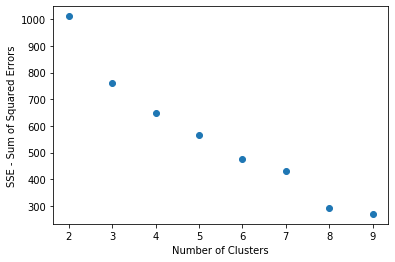

In [21]:
cluster_number = range(2,10)
plt.xlabel("Number of Clusters")
plt.ylabel('SSE - Sum of Squared Errors')
plt.scatter(cluster_number, errors)
plt.show()

In [23]:
#we will use K=8 (started with k=5)
from pyspark.ml.evaluation import ClusteringEvaluator
evaluatorObj = ClusteringEvaluator()

kmeans = KMeans(featuresCol='features', k=8).setSeed(5)
model = kmeans.fit(training_df)
intra_cluster_distance = model.computeCost(training_df)


predictions = model.transform(training_df)#predictions is which cluster was the datapoint assigned
#predictions.columns
silhouette_coeff = evaluatorObj.evaluate(predictions)
print('Silhouette Coefficient: ' + str(silhouette_coeff))
print("SSE = " + str(intra_cluster_distance))

Silhouette Coefficient: 0.6336770249427754
SSE = 290.5568747473954


In [23]:
# k = 4
# Silhouette Coefficient: 0.5363748226705073
# SSE = 602.0778569104061

# k = 5
# Silhouette Coefficient: 0.5535857307652398
# SSE = 464.0340605858044

# k = 6 
# Silhouette Coefficient: 0.6183247740108855
# SSE = 364.50309371549935

# k = 7 
# Silhouette Coefficient: 0.5129132096513541
# SSE = 431.0299635086193

# k = 8 
# Silhouette Coefficient: 0.6336770249427754
# SSE = 290.5568747473954

In [24]:
# I choose 8 clusters based on the best values for Silhouette coeffiecent and SSE
# SSE is the lowest with 290.56, and Silhouette coefficient gives us the best value regarding the quality of cluster with 0.63

In [24]:
#test dataset
evaluatorObj = ClusteringEvaluator()
test_model = kmeans.fit(test_df)
intra_cluster_distance = model.computeCost(test_df)


predictions_test = model.transform(test_df)

silhouette_coeff = evaluatorObj.evaluate(predictions_test)
print('Silhouette Coefficient: ' + str(silhouette_coeff))
print("SSE = " + str(intra_cluster_distance))

Silhouette Coefficient: 0.6312441830558223
SSE = 98.002724718211


In [26]:
#the Silhouette Coefficient is with 0.6312 a little lower than our training dataset but still good   
#the SSE is even lower with 98
#the training algorithm seems to be stable regarding Silhouette Coefficient
#SSE might vary because the dataset is smaller 

In [25]:
predictions_test.groupBy('prediction').count().show()
#group 0 has highest amount of trips, cluster 2 is very high as well
#cluster 1 has lowest amount of trips 
 

+----------+-----+
|prediction|count|
+----------+-----+
|         1|15085|
|         6|  119|
|         3| 3539|
|         5| 4962|
|         4| 1157|
|         7|  238|
|         2|53725|
|         0|61971|
+----------+-----+



In [28]:
predictions_test.groupBy('prediction', 'base').count().orderBy('prediction', ascending=False).show(60)
#all bases are present in all clusters (with a minimum of 1)
#cluster 0 has the highest amount of trips 
#cluster 2 the second highest amount of trips 

+----------+------+-----+
|prediction|  base|count|
+----------+------+-----+
|         7|B02598|   87|
|         7|B02512|   16|
|         7|B02682|   96|
|         7|B02764|    2|
|         7|B02617|   37|
|         6|B02682|   41|
|         6|B02512|   18|
|         6|B02598|   37|
|         6|B02617|   22|
|         6|B02764|    1|
|         5|B02764|   69|
|         5|B02512|  299|
|         5|B02598| 1553|
|         5|B02682| 2057|
|         5|B02617|  984|
|         4|B02598|  279|
|         4|B02512|  172|
|         4|B02617|  223|
|         4|B02764|   42|
|         4|B02682|  441|
|         3|B02617|  724|
|         3|B02682| 1487|
|         3|B02512|  162|
|         3|B02598| 1117|
|         3|B02764|   49|
|         2|B02598|17267|
|         2|B02682|21850|
|         2|B02764|  853|
|         2|B02512| 3914|
|         2|B02617| 9841|
|         1|B02764|  249|
|         1|B02617| 3141|
|         1|B02598| 5211|
|         1|B02512|  473|
|         1|B02682| 6011|
|         0|

In [ ]:
#number 8

#the following measures are not provided by Mlib, but could be used to evaluate kmeans:

# The Davies-Bouldin Index (davies bouldin score) evaluates the number of clusters and is available under the scikit package (sklearn.metrics). It evaluates intra-cluster similarity and inter-cluster differences - the lower the score the better
# The Calinski Harabaz score(also known as Variance Ratio Criterion) and is the ratio between the within-cluster dispersion and the between-cluster dispersion. It is available under the scikit package (sklearn.metrics) as well. The optimal cluster has a high index 
# The Dunn index is another measure to evaluate clustering. It is an internal clustering validation. For each cluster the distance between each object in the cluster and the objects in other clusters is computed. A high value implies better clustering.   